# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:
1) модель с 1 GRU слоем;
2) модель с 1 LSTM слоем
3) модель с 1 GRU и 1 LSTM слоем
4) модель с 1 BIGRU и 2 LSTM слоями
5) модель с 5 GRU слоями и 3 LSTM слоями
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Input
from tensorflow.keras.models import Sequential
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('lenta_40k.csv.zip')

In [5]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [6]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [8]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
len(vocab)

354611

In [11]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

24091

In [13]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [15]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [16]:
MAX_LEN = max(len(x) for x in X)

In [17]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [19]:
MAX_LEN = int(MEAN_LEN + 30)

In [20]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
X.shape

(44356, 200)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [23]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [24]:
len(label2id)

19

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [26]:
MAX_FEATURES = len(word2id)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, Bidirectional, Dense

models = []

# 1) Модель с 1 GRU слоем
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_1.add(GRU(128))
model_1.add(Dense(len(label2id), activation='softmax'))
models.append(model_1)

# 2) Модель с 1 LSTM слоем
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_2.add(LSTM(128))
model_2.add(Dense(len(label2id), activation='softmax'))
models.append(model_2)

# 3) Модель с 1 GRU и 1 LSTM слоем
model_3 = Sequential()
model_3.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_3.add(GRU(128, return_sequences=True))
model_3.add(LSTM(128))
model_3.add(Dense(len(label2id), activation='softmax'))
models.append(model_3)

# 4) Модель с 1 BIGRU и 2 LSTM слоями
model_4 = Sequential()
model_4.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_4.add(Bidirectional(GRU(128, return_sequences=True)))
model_4.add(LSTM(128, return_sequences=True))
model_4.add(LSTM(128))
model_4.add(Dense(len(label2id), activation='softmax'))
models.append(model_4)

# 5) Модель с 5 GRU слоями и 3 LSTM слоями
model_5 = Sequential()
model_5.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_5.add(GRU(128, return_sequences=True))
model_5.add(GRU(128, return_sequences=True))
model_5.add(GRU(128, return_sequences=True))
model_5.add(GRU(128, return_sequences=True))
model_5.add(GRU(128, return_sequences=True))
model_5.add(LSTM(128, return_sequences=True))
model_5.add(LSTM(128, return_sequences=True))
model_5.add(LSTM(128))
model_5.add(Dense(len(label2id), activation='softmax'))
models.append(model_5)

# 6) Модель с 1 BIGRU и 1 BILSTM слоями
forward_gru = GRU(128, return_sequences=True)
backward_gru = GRU(128, return_sequences=True, go_backwards=True)
forward_lstm = LSTM(128)
backward_lstm = LSTM(128, go_backwards=True)
model_6 = Sequential()
model_6.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_6.add(Bidirectional(forward_gru, backward_layer=backward_gru))
model_6.add(Bidirectional(forward_lstm, backward_layer=backward_lstm))
model_6.add(Dense(len(label2id), activation='softmax'))
models.append(model_6)

# 7) Модель с последовательностью слоев: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM
forward_lstm = LSTM(128, return_sequences=True)
backward_lstm = LSTM(128, return_sequences=True, go_backwards=True)
forward_gru = GRU(128, return_sequences=True)
backward_gru = GRU(128, return_sequences=True, go_backwards=True)
model_7 = Sequential()
model_7.add(Embedding(input_dim=len(word2id), output_dim=30, input_length=MAX_LEN))
model_7.add(LSTM(128, return_sequences=True))
model_7.add(GRU(128, return_sequences=True))
model_7.add(Bidirectional(forward_lstm, backward_layer=backward_lstm))
model_7.add(Bidirectional(forward_gru, backward_layer=backward_gru))
model_7.add(GRU(128, return_sequences=True))
model_7.add(LSTM(128))
model_7.add(Dense(len(label2id), activation='softmax'))
models.append(model_7)

# Компиляция всех моделей в списке
for model in models:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=[f1,
                           tf.keras.metrics.RecallAtPrecision(
                               0.8,
                               name='rec@prec'
                           )])

Training model 1
Epoch 1/20
43/43 [==============================] - 19s 266ms/step - loss: 2.5428 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3100 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
43/43 [==============================] - 8s 193ms/step - loss: 2.2416 - f1: 1.8558e-04 - rec@prec: 9.4926e-05 - val_loss: 2.2094 - val_f1: 6.6600e-04 - val_rec@prec: 0.0027
Epoch 3/20
43/43 [==============================] - 9s 204ms/step - loss: 2.0562 - f1: 0.0062 - rec@prec: 0.0019 - val_loss: 2.0026 - val_f1: 0.0218 - val_rec@prec: 0.0077
Epoch 4/20
43/43 [==============================] - 7s 173ms/step - loss: 1.8470 - f1: 0.0608 - rec@prec: 0.0035 - val_loss: 1.8379 - val_f1: 0.1094 - val_rec@prec: 0.0167
Epoch 5/20
43/43 [==============================] - 6s 149ms/step - loss: 1.6213 - f1: 0.2096 - rec@prec: 0.1297 - val_loss: 1.7919 - val_f1: 0.2848 - val_rec@prec: 0.0730
Epoch 6/20
43/43 [==============================] - 7s 163ms/step - loss: 1.4826 - f1: 0.3622 

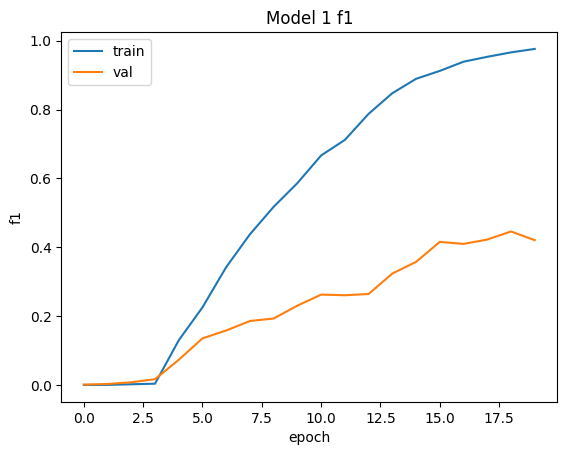

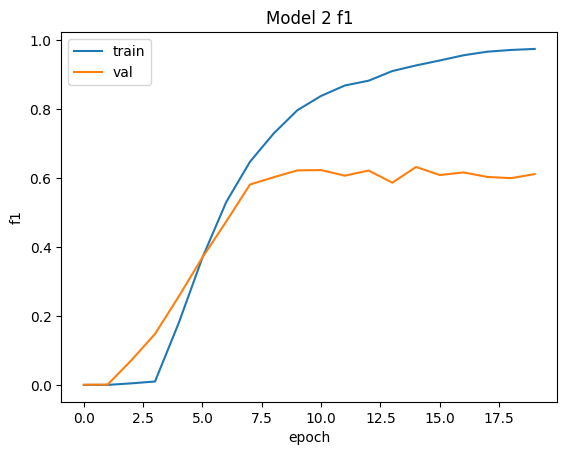

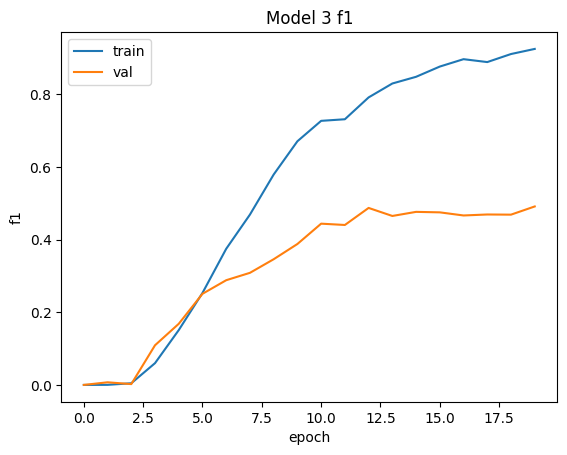

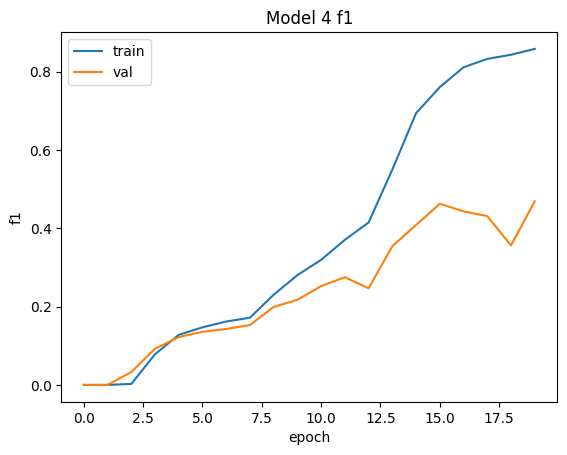

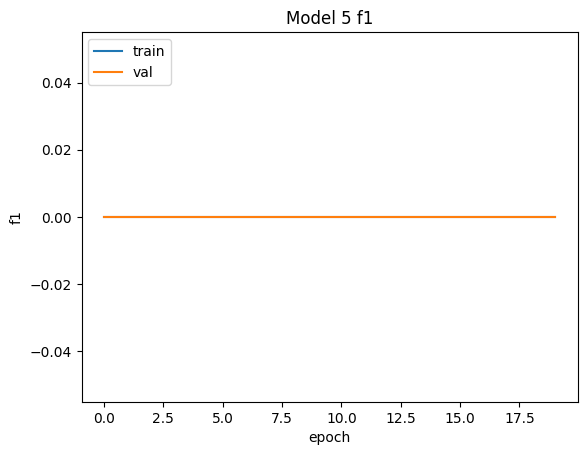

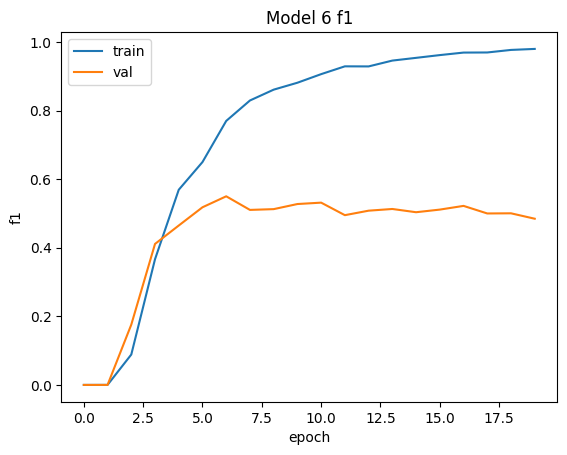

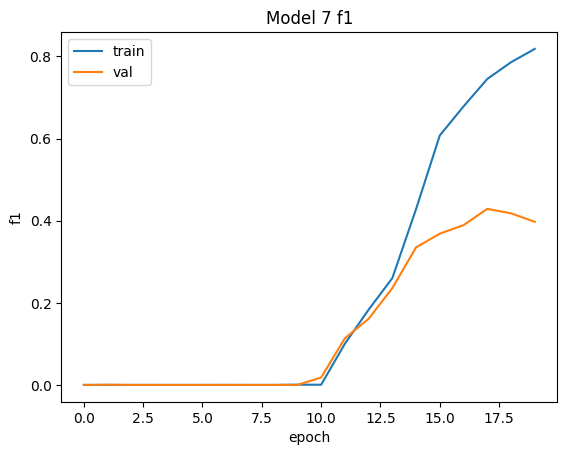

In [28]:
import matplotlib.pyplot as plt

history = []

for i, model in enumerate(models):
    print(f'Training model {i+1}')
    hist = model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     batch_size=1000,
                     epochs=20)
    history.append(hist)

for i, hist in enumerate(history):
    plt.plot(hist.history['rec@prec'])
    plt.plot(hist.history['val_rec@prec'])
    plt.title(f'Model {i+1} f1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [29]:
best_val_f1 = 0
best_model_index = 0

for i, hist in enumerate(history):
    val_f1 = hist.history['val_rec@prec'][-1]
    print(f'Model {i+1} val f1: {val_f1}')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_index = i

print(f'Best model: {best_model_index+1}')

Model 1 val f1: 0.4206492304801941
Model 2 val f1: 0.611361563205719
Model 3 val f1: 0.49098286032676697
Model 4 val f1: 0.468890905380249
Model 5 val f1: 0.0
Model 6 val f1: 0.48467087745666504
Model 7 val f1: 0.3972046971321106
Best model: 2


## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [30]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.1 MB/s eta 0:00:00


In [31]:
from datasets import load_dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
from sklearn.metrics import classification_report

In [32]:
# Load the Wikiann dataset
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
# Create a vocabulary from the training data
vocab = Counter()
for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [34]:
# Create word-to-index and index-to-word mappings
word2id = {'PAD':0, 'UNK':1}
for word in vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [35]:
# Convert the text data into sequences of word indices
X = []
for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)
X_test = []
for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [36]:
# Determine the maximum sequence length
MAX_LEN = max(len(x) for x in X)

In [37]:
# Pad the sequences with zeros
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [38]:
# Create label-to-index and index-to-label mappings
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [39]:
# Convert the labels into sequences of label indices
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [40]:
def create_model(model_type):
    inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
    embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

    if model_type == 'BiLSTM':
        rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
        rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(rnn_layer)
    elif model_type == 'BiGRU':
        rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
        rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(rnn_layer)

    outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [41]:
# Create and train a BiLSTM model
bilstm_model = create_model('BiLSTM')
bilstm_model.fit(X, y, validation_data=(X_test, y_test), batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 47s 205ms/step - loss: 0.2542 - accuracy: 0.9312 - val_loss: 0.1479 - val_accuracy: 0.9546
Epoch 2/5
157/157 [==============================] - 13s 84ms/step - loss: 0.1226 - accuracy: 0.9612 - val_loss: 0.1041 - val_accuracy: 0.9672
Epoch 3/5
157/157 [==============================] - 6s 41ms/step - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0.0615 - val_accuracy: 0.9819
Epoch 4/5
157/157 [==============================] - 7s 43ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.0545 - val_accuracy: 0.9843
Epoch 5/5
157/157 [==============================] - 5s 33ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0652 - val_accuracy: 0.9835


In [42]:
# Create and train a BiGRU model
bigru_model = create_model('BiGRU')
bigru_model.fit(X, y, validation_data=(X_test, y_test), batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 27s 127ms/step - loss: 0.2516 - accuracy: 0.9315 - val_loss: 0.1113 - val_accuracy: 0.9627
Epoch 2/5
157/157 [==============================] - 10s 65ms/step - loss: 0.0651 - accuracy: 0.9789 - val_loss: 0.0584 - val_accuracy: 0.9826
Epoch 3/5
157/157 [==============================] - 8s 48ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0519 - val_accuracy: 0.9856
Epoch 4/5
157/157 [==============================] - 7s 46ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0577 - val_accuracy: 0.9854
Epoch 5/5
157/157 [==============================] - 5s 31ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0651 - val_accuracy: 0.9847


In [43]:
# Evaluate the models using classification metrics
from sklearn.metrics import classification_report

bilstm_pred = bilstm_model.predict(X_test).argmax(2)
bilstm_rep = classification_report(y_test.reshape(-1), bilstm_pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0)
print('BiLSTM Model:')
print(bilstm_rep)

313/313 [==============================] - 3s 6ms/step
BiLSTM Model:
              precision    recall  f1-score   support

           O       0.90      0.97      0.94     40480
       B-PER       0.89      0.77      0.83      3542
       I-PER       0.92      0.81      0.86      7544
       B-ORG       0.83      0.62      0.71      4074
       I-ORG       0.90      0.73      0.81      8008
       B-LOC       0.63      0.83      0.71      4560
       I-LOC       0.84      0.72      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.86      0.80      0.83    540000
weighted avg       0.98      0.98      0.98    540000



In [44]:
bigru_pred = bigru_model.predict(X_test).argmax(2)
bigru_rep = classification_report(y_test.reshape(-1), bigru_pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0)
print('BiGRU Model:')
print(bigru_rep)

313/313 [==============================] - 4s 6ms/step
BiGRU Model:
              precision    recall  f1-score   support

           O       0.90      0.98      0.94     40480
       B-PER       0.89      0.85      0.87      3542
       I-PER       0.92      0.83      0.87      7544
       B-ORG       0.68      0.72      0.70      4074
       I-ORG       0.83      0.78      0.81      8008
       B-LOC       0.89      0.66      0.76      4560
       I-LOC       0.94      0.66      0.77      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.88      0.81      0.84    540000
weighted avg       0.98      0.98      0.98    540000



In [45]:
from sklearn.metrics import precision_recall_fscore_support

# Вычисляем метрики для модели BiLSTM
bilstm_precision, bilstm_recall, bilstm_fscore, _ = precision_recall_fscore_support(y_test.reshape(-1), bilstm_pred.reshape(-1), labels=list(id2labels.keys()))

# Вычисляем метрики для модели BiGRU
bigru_precision, bigru_recall, bigru_fscore, _ = precision_recall_fscore_support(y_test.reshape(-1), bigru_pred.reshape(-1), labels=list(id2labels.keys()))

# Вычитаем метрики одной модели из другой
diff_precision = bilstm_precision - bigru_precision
diff_recall = bilstm_recall - bigru_recall
diff_fscore = bilstm_fscore - bigru_fscore

# Выводим разницу в метриках
print('Difference in precision:', diff_precision)
print('Difference in recall:', diff_recall)
print('Difference in F-score:', diff_fscore)

Difference in precision: [ 1.50188827e-04  3.17879033e-03  8.95260688e-04  1.49448551e-01
  6.86521122e-02 -2.63512538e-01 -9.55322635e-02 -1.74890052e-04]
Difference in recall: [-0.00600296 -0.08159232 -0.02531813 -0.10333824 -0.0531968   0.16118421
  0.0630719   0.        ]
Difference in F-score: [-2.70692977e-03 -4.35487864e-02 -1.38022431e-02  8.21627243e-03
 -7.25649246e-04 -4.80917281e-02  3.00959136e-03 -8.74575242e-05]


In [47]:
import re

In [49]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [50]:
# Примеры для проверки
examples = ['Я поступил в ВШЭ в Питер',
            'Владимир Путин встретился с Джо Байденом в Женеве',
            'Apple выпустила новый iPhone']

for text in examples:
    print(f'Text: {text}')
    print('Model bilstm:')
    print(label_seq(text, word2id, id2labels, MAX_LEN, bilstm_model))
    print('Model bigru:')
    print(label_seq(text, word2id, id2labels, MAX_LEN, bigru_model))

Text: Я поступил в ВШЭ в Питер
Model bilstm:
1/1 [==============================] - 0s 36ms/step
[('Я', 'O'), ('поступил', 'O'), ('в', 'O'), ('ВШЭ', 'B-LOC'), ('в', 'I-LOC'), ('Питер', 'PAD')]
Model bigru:
1/1 [==============================] - 0s 33ms/step
[('Я', 'O'), ('поступил', 'O'), ('в', 'O'), ('ВШЭ', 'B-ORG'), ('в', 'I-ORG'), ('Питер', 'I-ORG')]
Text: Владимир Путин встретился с Джо Байденом в Женеве
Model bilstm:
1/1 [==============================] - 0s 38ms/step
[('Владимир', 'B-PER'), ('Путин', 'I-PER'), ('встретился', 'I-PER'), ('с', 'O'), ('Джо', 'B-PER'), ('Байденом', 'I-PER'), ('в', 'O'), ('Женеве', 'PAD')]
Model bigru:
1/1 [==============================] - 0s 38ms/step
[('Владимир', 'B-PER'), ('Путин', 'I-PER'), ('встретился', 'I-PER'), ('с', 'O'), ('Джо', 'B-PER'), ('Байденом', 'I-PER'), ('в', 'O'), ('Женеве', 'PAD')]
Text: Apple выпустила новый iPhone
Model bilstm:
1/1 [==============================] - 0s 41ms/step
[('Apple', 'B-PER'), ('выпустила', 'I-PER'), ('нов